# Importing Libraries

In [1]:
# imports 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from utills import set_seed
import pickle
import os

In [2]:
set_seed()

## Loading Data
We are using our data_setup python script to load digital modulations from RML2016.10a Dataset
and also creating train and test splits  

In [9]:
from data_setup import load_data , load_digital_mods

data = load_data(path='RML2016.10a/RML2016.10a_dict.pkl')
X_train , y_train , X_test , y_test, mods = load_digital_mods(data=data , ratio= 0.2)
print(f"shape of the train and test **samples** are --> {X_train.shape , X_test.shape}")
print(f"shape of the train and test **labels** are --> {y_train.shape , y_test.shape}")

shape of the train and test **samples** are --> ((128000, 2, 128), (32000, 2, 128))
shape of the train and test **labels** are --> ((128000, 2), (32000, 2))


### Fitting a label encoder
Fitting a label encoder inorder to convert the labels into integer

In [5]:
type(data) , type(X_train), type(y_train)

(dict, numpy.ndarray, numpy.ndarray)

In [10]:
# fit a label encoder to transform the labels into one-hot encodings
label_encoder = LabelEncoder()
label_encoder.fit(list(set(y_train[:,0])))

LabelEncoder()

### Converting train and test arrays into Tensors
* first reshaping out input data to have the following shape : ( samples, number_of_channels = 1 , 2 , 128)
* then converting the labels using the label_encoder
* finally creating DataLoaders for out model

In [11]:
X_train = X_train.reshape(-1,1,2,128)
X_test = X_test.reshape(-1,1,2,128)
y_train_encoded = label_encoder.transform(y_train[:,0]).astype(np.float32)
y_test_encoded = label_encoder.transform(y_test[:,0]).astype(np.float32)

In [7]:
type(data) , type(X_train), type(y_train)

(dict, numpy.ndarray, numpy.ndarray)

In [13]:
# Convert train arrays to PyTorch tensors

train_tensor = torch.tensor(X_train, dtype=torch.float)
train_targets_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Convert test arrays to PyTorch tensors
test_tensor = torch.tensor(X_test, dtype=torch.float)
test_targets_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create a TensorDataset
trainset = TensorDataset(train_tensor, train_targets_tensor)
testset = TensorDataset(test_tensor, test_targets_tensor)

In [14]:
train_dataloader = DataLoader(dataset = trainset,
                              batch_size= 1024,
                              shuffle=True)
test_dataloader = DataLoader(dataset = testset,
                             batch_size= 1024,
                             shuffle=False)

## Creating model's class
Here we are using Pytorch to creat our CNN model

In [17]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1, 3), padding='same'),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2, 3), padding='same'),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.AvgPool2d(kernel_size = (2,2))
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(5120, 256),
            nn.ReLU(),
            nn.Linear(256, 8)
        )
    
    def filters_output(self,x):
        return self.conv_block(x)

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                # Initialize weights using Xavier initialization
                init.xavier_uniform_(module.weight)
                # Initialize biases to zeros
                if module.bias is not None:
                    init.constant_(module.bias, 0.0)

    def forward(self, x):
        return self.fc_layers(self.conv_block(x))

## Training the Model

for training we are using the  `train_functions` python script

this script includes functions to train a model and returning the results of the  
train and test results in each epoch

In [35]:
from train_functions import train

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set number of epochs
NUM_EPOCHS = 50
# initial the loss function and ompitmizer
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()

In [36]:
# intial the model
cnn_model = CNNModel().to(device)
cnn_model.initialize_weights()
optimizer = optim.AdamW(cnn_model.parameters(), lr=learning_rate)

results = train(model=cnn_model, 
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer=optimizer,
                criterion=loss_function, 
                epochs=NUM_EPOCHS,
                device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0795 | train_acc: 0.1265 | test_loss: 2.0792 | test_acc: 0.1272
Epoch: 2 | train_loss: 2.0061 | train_acc: 0.1815 | test_loss: 1.8494 | test_acc: 0.2785
Epoch: 3 | train_loss: 1.7123 | train_acc: 0.3116 | test_loss: 1.5754 | test_acc: 0.3548
Epoch: 4 | train_loss: 1.5489 | train_acc: 0.3616 | test_loss: 1.4911 | test_acc: 0.3932
Epoch: 5 | train_loss: 1.4782 | train_acc: 0.3960 | test_loss: 1.4261 | test_acc: 0.4161
Epoch: 6 | train_loss: 1.4053 | train_acc: 0.4234 | test_loss: 1.3390 | test_acc: 0.4498
Epoch: 7 | train_loss: 1.3546 | train_acc: 0.4453 | test_loss: 1.3073 | test_acc: 0.4575
Epoch: 8 | train_loss: 1.3196 | train_acc: 0.4555 | test_loss: 1.2741 | test_acc: 0.4667
Epoch: 9 | train_loss: 1.2919 | train_acc: 0.4662 | test_loss: 1.2665 | test_acc: 0.4608
Epoch: 10 | train_loss: 1.2736 | train_acc: 0.4729 | test_loss: 1.2384 | test_acc: 0.4785
Epoch: 11 | train_loss: 1.2483 | train_acc: 0.4835 | test_loss: 1.2525 | test_acc: 0.4788
Epoch: 12 | train_l

In [37]:
from train_functions import plot_loss, plot_accuracy

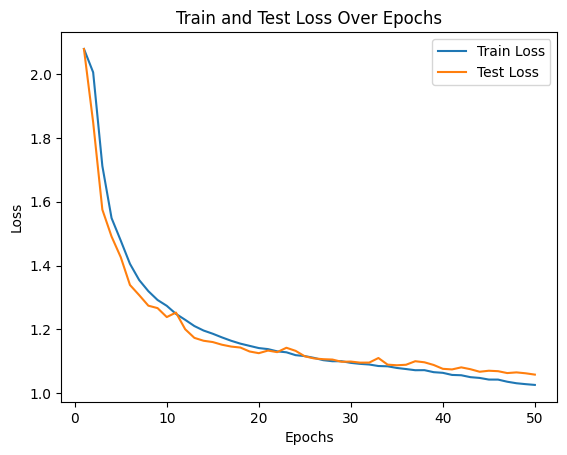

In [38]:
plot_loss(results)

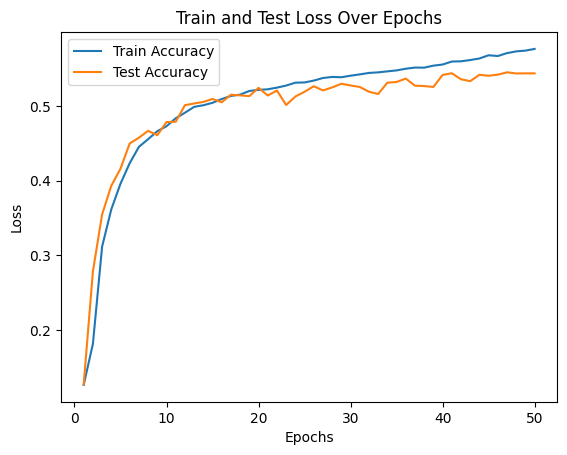

In [39]:
plot_accuracy(results)

## Saving the results
here we save the model itself, its label encoder, and the train and test loss

In [11]:
from utills import save_model, save_label_encoder, save_metrics

save_model(model = cnn_model,
           dir_path = "cnn_models",
           file_name = "cnnModel")

save_label_encoder(label_encoder=label_encoder,
                   dir_path = "label_encoders",
                    file_name = "LabelEncoder" )

save_metrics(metrics= results,
             dir_path = "models_results",
             file_name = "cnnModel" )


Model saved to cnn_models\cnnModel
LabelEncoder saved to label_encoders\LabelEncoder
Metrics saved to models_results\cnnModel


## Validation phase

in this section we validate the model's performance and
print out the confusion matrices and some metrics.

Loading model and label encoder

In [23]:
from utills import load_label_encoder , load_model

labelencoder = load_label_encoder(file_path= "label_encoders/LabelEncoder")
cnn_model = CNNModel()
cnn_model = load_model(model= cnn_model , file_path= "cnn_models/cnnModel")
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model.to(device)

LabelEncoder loaded from label_encoders/LabelEncoder
Model loaded from cnn_models/cnnModel


CNNModel(
  (conv_block): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=8, bias=True)
  )
)

In [24]:
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

defining a list to append the predictions  into it

In [25]:
y_preds = []
with torch.inference_mode():
    for data , label in test_dataloader:
        X = data.to(device)
        output = cnn_model(X)
        
        # appending the labels as their str format
        main_pred_lbl = label_encoder.inverse_transform(output.argmax(dim=1,keepdim=True).cpu())
        y_preds.append(main_pred_lbl)

c:\Users\shahr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shahr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shahr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shahr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.p

In [26]:
y_preds_flat = [item for sublist in y_preds for item in sublist]

In [27]:
# again fitting a lebel encoder to turn the predictions into integers

class_names = list(set(y_test[:,0]))
# Create and fit LabelEncoder
le = LabelEncoder()
le.fit(class_names)

# Encode predictions and true labels
y_preds_encoded = le.transform(y_preds_flat)
y_test_encoded = le.transform(y_test[:,0])

# Convert numpy arrays to PyTorch tensors
y_preds_tensor = torch.tensor(y_preds_encoded)
y_true_tensor = torch.tensor(y_test_encoded)

In [28]:
snr_index = []
for i in range(-20,20,2):
    snrs = bytes(str(i), 'utf-8')
    snr_index.append([y_test[:,1] == snrs])

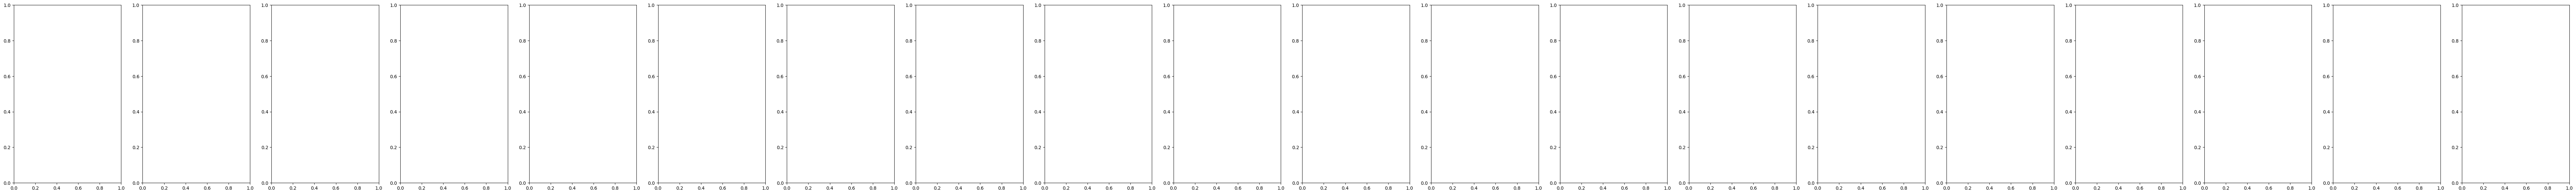

In [29]:
# Number of subplots (one for each SNR index)
num_plots = len(snr_index)

number_of_classes = len(class_names)
confmat = ConfusionMatrix(num_classes = number_of_classes, task='multiclass')

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(5 * num_plots, 7))

# Ensure axes is iterable
if num_plots == 1:
    axes = [axes]

In [30]:
# defining a accuaracy function to calculate acc at each SNR further in the code

def accuracy(predictions , true_labels):
    
    correct_predictions = (predictions == true_labels).sum().item()
    
    return (correct_predictions / len(predictions))

in this snippet we print the confusion matrix at each snr.  
and then calculate the accuracy and save it at a list  
then save each plot at the desired path

In [31]:
# Create a folder if it doesn't exist
save_folder = 'confusion_matrices'
if not os.path.exists(save_folder):
    os.makedirs(save_folder, exist_ok=True)

snr_acc_list = []
snrs = range(-20,20,2)
for i, snr_i in enumerate(snr_index):

    confmat_tensor = confmat(preds=y_preds_tensor[snr_i[0]], target=y_true_tensor[snr_i[0]])
    # Convert the confusion matrix tensor to a NumPy array
    cm = confmat_tensor.cpu().numpy()

    # Convert confusion matrix to percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    acc = accuracy(predictions= y_preds_tensor[snr_i[0]], true_labels = y_true_tensor[snr_i[0]])
    acc = acc * 100
    snr_acc_list.append([acc,snrs[i]])

    _ , axes[i] = plot_confusion_matrix(conf_mat=cm_percent, # matplotlib likes working with NumPy 
                                    class_names=le.classes_, # turn the row and column labels into class names
                                    )
    axes[i].set_title(f'SNR : {snrs[i]} , accuracy = {acc:.2f}%')

    save_path = os.path.join(save_folder, f'confusion_matrix_at_SNR{snrs[i]}.jpeg')
    plt.savefig(save_path, format='jpeg')
    plt.close()

here we use `sklearn.metrics` to print out some validation metrics

In [32]:
from sklearn.metrics import classification_report

# 2. Accuracy as a Percentage
accuracy = (y_preds_tensor == y_true_tensor).sum().item() / len(y_true_tensor) * 100
print(f'Accuracy: {accuracy:.2f}%')

# Convert tensors to NumPy for classification_report
y_preds = y_preds_tensor.cpu().numpy()
y_true = y_true_tensor.cpu().numpy()

# Generate classification report
report = classification_report(y_true, y_preds, output_dict=True)

# Convert to percentages and display for each class
for label, metrics in report.items():
    if isinstance(metrics, dict):  # Ignore 'accuracy' field
        precision = metrics['precision'] * 100
        recall = metrics['recall'] * 100
        f1_score = metrics['f1-score'] * 100
        support = metrics['support']
        print(f"Class {label}: Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1-Score: {f1_score:.2f}%, Support: {support}")

# 4. Macro and Weighted Metrics as Percentages
macro_precision = report['macro avg']['precision'] * 100
macro_recall = report['macro avg']['recall'] * 100
macro_f1_score = report['macro avg']['f1-score'] * 100
print(f"Macro Avg: Precision: {macro_precision:.2f}%, Recall: {macro_recall:.2f}%, F1-Score: {macro_f1_score:.2f}%")

Accuracy: 55.04%
Class 0: Precision: 47.10%, Recall: 48.40%, F1-Score: 47.74%, Support: 4000.0
Class 1: Precision: 62.29%, Recall: 63.35%, F1-Score: 62.82%, Support: 4000.0
Class 2: Precision: 56.62%, Recall: 65.77%, F1-Score: 60.85%, Support: 4000.0
Class 3: Precision: 62.90%, Recall: 70.60%, F1-Score: 66.53%, Support: 4000.0
Class 4: Precision: 71.27%, Recall: 69.77%, F1-Score: 70.52%, Support: 4000.0
Class 5: Precision: 40.71%, Recall: 32.52%, F1-Score: 36.16%, Support: 4000.0
Class 6: Precision: 49.86%, Recall: 40.38%, F1-Score: 44.62%, Support: 4000.0
Class 7: Precision: 45.73%, Recall: 49.55%, F1-Score: 47.56%, Support: 4000.0
Class macro avg: Precision: 54.56%, Recall: 55.04%, F1-Score: 54.60%, Support: 32000.0
Class weighted avg: Precision: 54.56%, Recall: 55.04%, F1-Score: 54.60%, Support: 32000.0
Macro Avg: Precision: 54.56%, Recall: 55.04%, F1-Score: 54.60%


at the end you can the model's **accuracy vs snr** 

In [33]:
snr_acc_arr = np.array(snr_acc_list)

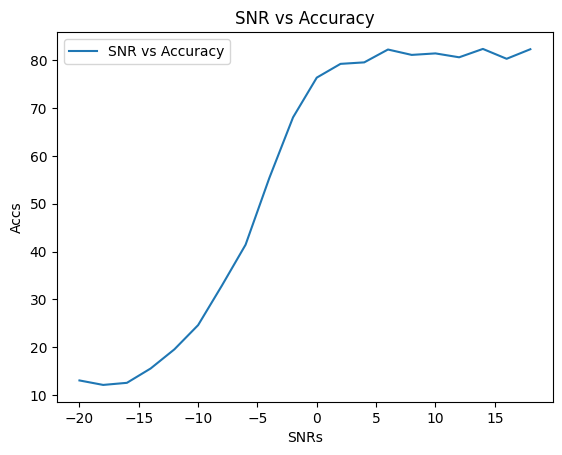

In [34]:

plt.plot(snr_acc_arr[:,1], snr_acc_arr[:,0], label='SNR vs Accuracy')

# Adding labels and title
plt.xlabel('SNRs')
plt.ylabel('Accs')
plt.title('SNR vs Accuracy')

# Adding a legend
plt.legend()

# Show the plot
plt.show()